In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, ElasticNet
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder as onehot
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error
import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor
from scipy.stats import spearmanr, stats
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier
from statsmodels.tsa.stattools import pacf
from scipy import signal
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [23]:
de_train_final = pd.read_csv('./data/de_train_final.csv')
y_de_train = pd.read_csv('./data/y_de_train.csv')
fr_train_final = pd.read_csv('./data/fr_train_final.csv')
y_fr_train = pd.read_csv('./data/y_fr_train.csv')

de_test_final = pd.read_csv('./data/de_test_final.csv')
fr_test_final = pd.read_csv('./data/fr_test_final.csv')

In [24]:
de_train_final.head()

,ID,DE_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_EXPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_WINDPOW,...,DE_SOLAR_prev_day,DE_WINDPOW_prev_day,DE_LIGNITE_prev_day,DE_RESIDUAL_LOAD_prev_day,DE_RAIN_prev_day,DE_WIND_prev_day,DE_TEMP_prev_day,GAS_RET_prev_day,COAL_RET_prev_day,CARBON_RET_prev_day
0,0,0.583923,0.778353,0.931374,0.836731,0.200623,0.076310,0.780177,0.390828,-0.012385,...,0.500201,0.066511,0.790924,0.200128,-0.000759,-0.385935,-1.461775,-0.401694,0.718941,-2.161340
1,2,0.548187,-0.179177,0.588670,1.062806,0.292958,-0.487960,0.832773,0.447086,-0.329384,...,0.500201,0.066511,0.790924,0.200128,-0.000759,-0.385935,-1.461775,-0.401694,0.718941,-2.161340
2,3,0.470907,-0.707035,0.111881,1.223117,0.150620,0.044238,0.842046,-0.053067,-0.446433,...,0.447086,-0.329384,0.722983,0.529501,-0.274901,-0.248671,-1.817422,1.596267,1.409234,0.593396
3,4,0.284447,0.389806,1.506291,0.202693,-0.665840,-0.738709,0.126256,1.431625,0.465544,...,-0.053067,-0.446433,0.707787,0.738900,-0.672022,-0.409482,-2.170678,0.172622,-0.847545,-0.313360
4,5,0.551274,0.226737,1.205343,0.637224,-0.746381,-0.014076,0.131863,1.377499,0.639742,...,1.431625,0.465544,0.500184,-0.656051,-0.300883,-0.444411,-0.795390,-1.951199,0.273857,-1.847703


In [25]:
print("de_train_final with shape:", de_train_final.shape)
print("y_de_train with shape:", y_de_train.shape)
print("fr_train_final with shape:", fr_train_final.shape)
print("y_fr_train with shape:", y_fr_train.shape)
print("de_test_final with shape:", de_test_final.shape)
print("fr_test_final with shape:", fr_test_final.shape)

de_train_final with shape: (643, 35)
y_de_train with shape: (643, 1)
fr_train_final with shape: (851, 35)
y_fr_train with shape: (851, 1)
de_test_final with shape: (289, 35)
fr_test_final with shape: (365, 35)


In [26]:
X = de_train_final
y = y_de_train

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Train the model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(x_test)

# Calculate Spearman Correlation
spearman_corr_lr, _ = spearmanr(y_test, y_pred_lr)
spearman_corr_lr_value = spearman_corr_lr.item()

# Print
print(f"Spearman Correlation for Linear Regression: {spearman_corr_lr_value:.1%}")

Spearman Correlation for Linear Regression: 71.0%


In [27]:
# Split the data
X_de = de_train_final
y_de = y_de_train
X_trainde, X_testde, Y_trainde, Y_testde = train_test_split(X_de, y_de, test_size=0.30, random_state=42)

X_fr = fr_train_final
y_fr = y_fr_train
X_trainfr, X_testfr, Y_trainfr, Y_testfr = train_test_split(X_fr, y_fr, test_size=0.30, random_state=42)

In [28]:

def metric_train(output, truth):
    return spearmanr(output, truth).correlation


def get_model(model_name, best_param=None):
    if model_name == 'dt':
        model = DecisionTreeRegressor(**(best_param if best_param else {}))
    elif model_name == 'bagging_ridge':
        base_model = Ridge(**(best_param['base_model'] if best_param and 'base_model' in best_param else {}))
        model = BaggingRegressor(base_estimator=base_model, n_estimators=10, random_state=42, **(best_param['model'] if best_param and 'model' in best_param else {}))
    elif model_name == 'extra_trees':
        model = ExtraTreesRegressor(**(best_param if best_param else {}))
    elif model_name == 'rf':
        model = RandomForestRegressor(**(best_param if best_param else {}))
    elif model_name == 'bagging_knn':
        base_model = KNeighborsRegressor(**(best_param['base_model'] if best_param and 'base_model' in best_param else {}))
        model = BaggingRegressor(base_estimator=base_model, n_estimators=10, random_state=42, **(best_param['model'] if best_param and 'model' in best_param else {}))
    elif model_name == 'bagging_svr':
        base_model = SVR(**(best_param['base_model'] if best_param and 'base_model' in best_param else {}))
        model = BaggingRegressor(base_estimator=base_model, n_estimators=10, random_state=42, **(best_param['model'] if best_param and 'model' in best_param else {}))
    elif model_name == 'bagging_linear':
        base_model = LinearRegression(**(best_param['base_model'] if best_param and 'base_model' in best_param else {}))
        model = BaggingRegressor(base_estimator=base_model, n_estimators=10, random_state=42, **(best_param['model'] if best_param and 'model' in best_param else {}))
    elif model_name == 'adaboost':
        model = AdaBoostRegressor(**(best_param if best_param else {}))
    elif model_name == 'gradient_boosting':
        model = GradientBoostingRegressor(**(best_param if best_param else {}))
    elif model_name == 'xgboost':
        model = XGBRegressor(**(best_param if best_param else {}))
    else:
        raise ValueError('Unknown Model')
    return model
        
scorer_train = make_scorer(metric_train)

In [ ]:
model_names = [
    'dt',  # Decision Tree Regressor
    'bagging_ridge',  # Bagging model based on Ridge regression
    'extra_trees',  # Extra Trees Regressor
    'rf',  # Random Forest Regressor
    'bagging_knn',  # Bagging model based on KNN regression
    'bagging_svr',  # Bagging model based on SVR
    'bagging_linear',  # Bagging model based on Linear regression
    'adaboost',  # AdaBoost Regressor
    'gradient_boosting' , # Gradient Boosting Regressor
    'xgboost' #Xgboost Regressor
]

# Train and evaluate models
results = []

for model_name in model_names:
    model = get_model(model_name)
    
    # Train on DE dataset
    model.fit(X_trainde, Y_trainde)
    predictions_de = model.predict(X_testde)
    score_de = metric_train(predictions_de, Y_testde)
    
    # Train on FR dataset
    model.fit(X_trainfr, Y_trainfr)
    predictions_fr = model.predict(X_testfr)  
    score_fr = metric_train(predictions_fr, Y_testfr)
    
    # Overall Score
    predictions_overall = np.concatenate((predictions_de, predictions_fr))
    truth_overall = np.concatenate((Y_testde, Y_testfr))
    score_overall = metric_train(predictions_overall, truth_overall)
    
    results.append({
        'Model': model_name,
        'DE_Score': score_de,
        'FR_Score': score_fr,
        'Overall_Score': score_overall  
    })

# Convert results to DataFrame for better visualization
import pandas as pd
results_df = pd.DataFrame(results)

In [30]:
print(results_df)

               Model  DE_Score  FR_Score  Overall_Score
0                 dt  0.522973  0.063219       0.272966
1      bagging_ridge  0.768485  0.232256       0.526632
2        extra_trees  0.718865  0.099351       0.410986
3                 rf  0.671317  0.061491       0.366640
4        bagging_knn -0.242485  0.123651      -0.042472
5        bagging_svr -0.075682  0.089942      -0.035366
6     bagging_linear  0.772510  0.228310       0.525331
7           adaboost  0.560786  0.106137       0.296425
8  gradient_boosting  0.650112  0.046904       0.354568
9            xgboost  0.698499  0.084659       0.398867


## Feature Importance

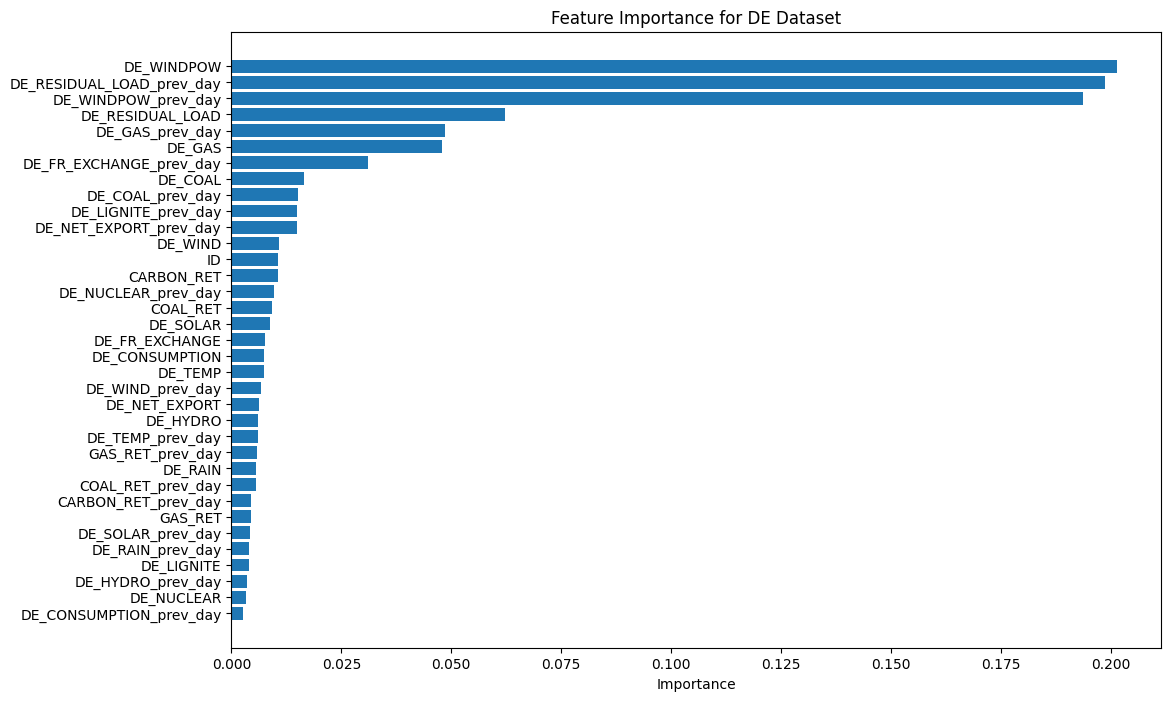

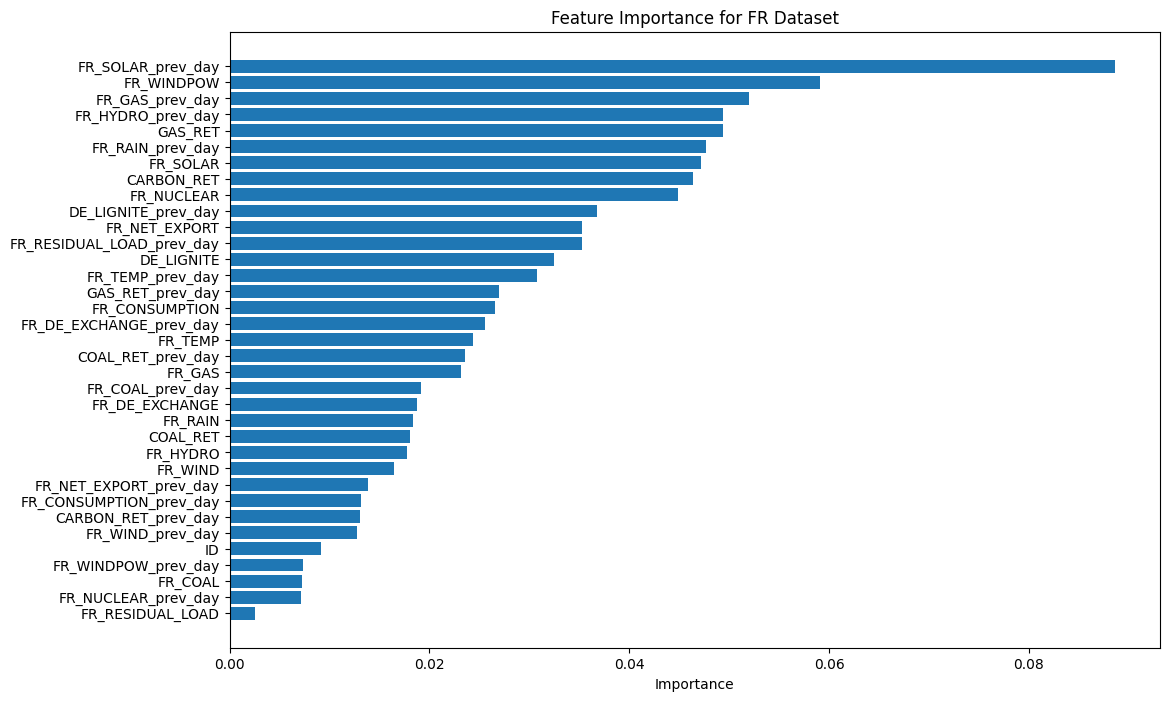

In [31]:
# Train XGBoost model on German dataset
model_de = XGBRegressor()
model_de.fit(X_trainde, Y_trainde)

# Obtain feature importances and feature names
feature_importances_de = model_de.feature_importances_
feature_names_de = X_trainde.columns.tolist()  # Get feature names

# Create DataFrame for feature names and their importance scores
feature_importance_de = pd.DataFrame({'Feature Name': feature_names_de, 'Importance': feature_importances_de})

# Sort features by importance in descending order
feature_importance_de.sort_values(by='Importance', ascending=False, inplace=True)

# Visualize feature importance for the German dataset
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_de['Feature Name'], feature_importance_de['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for DE Dataset')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

# Train XGBoost model on French dataset
model_fr = XGBRegressor()
model_fr.fit(X_trainfr, Y_trainfr)

# Obtain feature importances and feature names
feature_importances_fr = model_fr.feature_importances_
feature_names_fr = X_trainfr.columns.tolist()  # Get feature names

# Create DataFrame for feature names and their importance scores
feature_importance_fr = pd.DataFrame({'Feature Name': feature_names_fr, 'Importance': feature_importances_fr})

# Sort features by importance in descending order
feature_importance_fr.sort_values(by='Importance', ascending=False, inplace=True)

# Visualize feature importance for the French dataset
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_fr['Feature Name'], feature_importance_fr['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for FR Dataset')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()



## Tuning

In [ ]:
best_models = results_df.nlargest(5, 'Overall_Score')['Model']

estimators = []
for model_name in best_models:
    if model_name == 'dt':
        estimator = DecisionTreeRegressor()
    elif model_name == 'bagging_ridge':
        estimator = BaggingRegressor(base_estimator=RidgeCV())
    elif model_name == 'extra_trees':
        estimator = ExtraTreesRegressor()
    elif model_name == 'rf':
        estimator = RandomForestRegressor()
    elif model_name == 'bagging_knn':
        estimator = BaggingRegressor(base_estimator=KNeighborsRegressor())
    elif model_name == 'bagging_svr':
        estimator = BaggingRegressor(base_estimator=SVR())
    elif model_name == 'bagging_linear':
        estimator = BaggingRegressor(base_estimator=LinearRegression())
    elif model_name == 'adaboost':
        estimator = AdaBoostRegressor()
    elif model_name == 'gradient_boosting':
        estimator = GradientBoostingRegressor()
    elif model_name == 'xgboost':
        estimator = XGBRegressor()
    else:
        raise ValueError('Unknown Model')
    
    estimators.append((model_name, estimator))

# Define Stacking Model
stacking_model = StackingCVRegressor(regressors=[estimator for _, estimator in estimators], 
                                     meta_regressor=RidgeCV(),
                                     cv=5,
                                     use_features_in_secondary=True,
                                     random_state=42)

# Train and evaluate models
results = []

model_name = 'stacking_model'

model = stacking_model
    
# Train on DE dataset
model.fit(X_trainde, Y_trainde)
predictions_de = model.predict(X_testde)
score_de = metric_train(predictions_de, Y_testde)

# Train on FR dataset
model.fit(X_trainfr, Y_trainfr)
predictions_fr = model.predict(X_testfr)  
score_fr = metric_train(predictions_fr, Y_testfr)

# Overall Score
predictions_overall = np.concatenate((predictions_de, predictions_fr))
truth_overall = np.concatenate((Y_testde, Y_testfr))
score_overall = metric_train(predictions_overall, truth_overall)

results.append({
    'Model': model_name,
    'DE_Score': score_de,
    'FR_Score': score_fr,
    'Overall_Score': score_overall  
})

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)


In [33]:
print(best_models)

1     bagging_ridge
6    bagging_linear
2       extra_trees
9           xgboost
3                rf
Name: Model, dtype: object


In [34]:
print(results_df)

            Model  DE_Score  FR_Score  Overall_Score
0  stacking_model  0.748922  0.267832       0.515527


In [ ]:
de_train_pred = stacking_model.predict(X_de)
de_train = de_train_final.reset_index()
de_train['TARGET'] = de_train_pred
de_train = de_train[['ID', 'TARGET']]


In [36]:
# Print Coefficient of each base model

meta_coef = stacking_model.meta_regr_.coef_
meta_coef_base_models = meta_coef[:len(estimators)]
model_coefficients = dict(zip([name for name, _ in estimators], meta_coef_base_models))

for model_name, coef in model_coefficients.items():
    print(f"{model_name}: {coef}")

coefficients_df = pd.DataFrame(list(model_coefficients.items()), columns=['Model', 'Coefficient'])
print(coefficients_df)


bagging_ridge: -0.0008048885341906953
bagging_linear: 0.684127999078513
extra_trees: 0.15654743663619447
xgboost: -0.09832752359262037
rf: -0.26806470339512656
            Model  Coefficient
0   bagging_ridge    -0.000805
1  bagging_linear     0.684128
2     extra_trees     0.156547
3         xgboost    -0.098328
4              rf    -0.268065


In [ ]:
de_test = stacking_model.predict(de_test_final)
de_test_pred = de_test_final.reset_index()
de_test_pred['TARGET'] = de_test
de_test_pred = de_test_pred[['ID', 'TARGET']]

In [ ]:
fr_train_pred = stacking_model.predict(X_fr)
fr_result = fr_train_final.reset_index()
fr_result['TARGET'] = fr_train_pred
fr_result = fr_result[['ID', 'TARGET']]

In [ ]:
fr_test = stacking_model.predict(fr_test_final)
fr_test_pred = fr_test_final.reset_index()
fr_test_pred['TARGET'] = fr_test
fr_test_pred = fr_test_pred[['ID', 'TARGET']]

In [40]:
df_test = pd.read_csv('../challenge_data/X_test.csv')
test_pred = pd.DataFrame()
test_pred['ID'] = df_test['ID']

test_pred = test_pred.merge(de_test_pred[['ID', 'TARGET']], on='ID', how='left')
test_pred = test_pred.merge(fr_test_pred[['ID', 'TARGET']], on='ID', how='left')
test_pred['TARGET'] = test_pred['TARGET_x'].combine_first(test_pred['TARGET_y'])
test_pred = test_pred.drop(['TARGET_x', 'TARGET_y'], axis=1)

In [41]:
test_pred

,ID,TARGET
0,1115,-0.038182
1,1202,-0.394278
2,1194,0.245161
3,1084,0.115143
4,1135,-0.326274
...,...,...
649,879,-2.304406
650,673,-1.114567
651,1641,0.086449
652,712,3.691969


In [42]:
#test_pred.to_csv('./Submission/' + 'stack1_test' + '.csv', index=False)